In [18]:
import numpy as np
import pandas as pd
import re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords

In [3]:
df = pd.read_csv('fake_train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.shape

(20800, 5)

In [5]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
df = df.fillna('')
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [7]:
df['combined'] = df['author']+' '+df['title']
df.head()

,id,title,author,text,label,combined
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...


In [9]:
X = df.drop(columns='label', axis=1)
Y = df['label']

print(X.shape)
print(Y.shape)

(20800, 5)
(20800,)


# Data preprocessing

In [10]:
# Remove suffixes from words with PorterStemmer
ps = PorterStemmer()

def stemming(text):
    stemmed_text = re.sub('[^a-zA-Z]', ' ', text)
    stemmed_text = stemmed_text.lower()
    stemmed_text = stemmed_text.split()
    stemmed_text = [ps.stem(word) for word in stemmed_text if word not in stopwords.words('english')]
    stemmed_text = ' '.join(stemmed_text)
    return stemmed_text

In [11]:
df['combined'] = df['combined'].apply(stemming)
df['combined'].head()

0    darrel lucu hous dem aid even see comey letter...
1    daniel j flynn flynn hillari clinton big woman...
2               consortiumnew com truth might get fire
3    jessica purkiss civilian kill singl us airstri...
4    howard portnoy iranian woman jail fiction unpu...
Name: combined, dtype: object

In [12]:
X = df['combined'].values
Y = df['label'].values
print(X)
print(Y)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']
[1 0 1 ... 0 1 1]


# Building the models

Model: lr, Accuracy: 0.9787
Model: rf, Accuracy: 0.9929
Model: gb, Accuracy: 0.9656


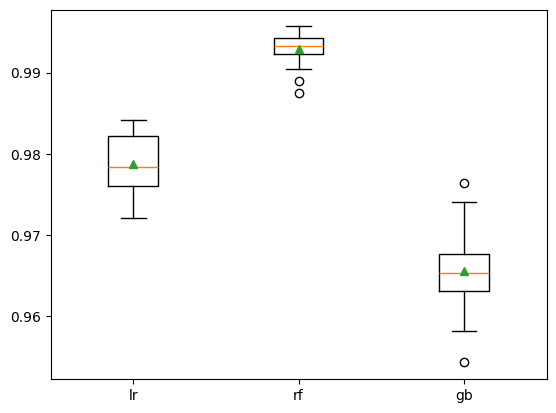

In [19]:
def get_models():
    models = dict()
    
    vectorizer = TfidfVectorizer()
    models['lr'] = Pipeline(steps=[('v', vectorizer), ('m', LogisticRegression())])
    models['rf'] = Pipeline(steps=[('v', vectorizer), ('m', RandomForestClassifier())])
    models['gb'] = Pipeline(steps=[('v', vectorizer), ('m', GradientBoostingClassifier())])
    
    return models

models = get_models()
names, results = list(), list()

for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv)
    names.append(name)
    results.append(scores)
    print(f"Model: {name}, Accuracy: {round(np.mean(scores), 4)}")
    
plt.boxplot(results, tick_labels=names, showmeans=True)
plt.show()